In [ ]:
! pip install datasets
! pip install transformers
! pip install diffusers
!pip install  ftfy accelerate  bitsandbytes 
! pip install huggingface_hub 

In [1]:
from datasets import load_dataset
dataset = load_dataset('HighCWu/diffusiondb_2m_first_5k_canny')

  0%|          | 0/1 [00:00<?, ?it/s]

In [2]:
dataset = dataset["train"]
dataset

Dataset({
    features: ['image', 'guide', 'text'],
    num_rows: 5000
})

In [3]:
from datasets import concatenate_datasets

data1 = dataset.remove_columns(["guide"])
data2 = dataset.remove_columns(["image"]).rename_column("guide", "image")
dataset = concatenate_datasets([data1, data2])
dataset = concatenate_datasets([dataset, data1])
dataset = dataset.rename_column("text", "caption")

In [4]:
dataset

Dataset({
    features: ['image', 'caption'],
    num_rows: 15000
})

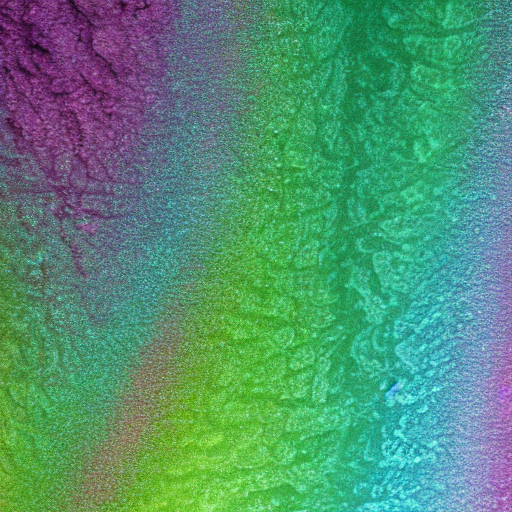

In [ ]:
dataset[100]["image"]

In [5]:
from PIL import Image
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows * cols
    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

In [2]:
# image_grid(dataset[:10]["image"], rows=2, cols=5)

In [3]:
# image_grid(dataset[110:120]["image"], rows=2, cols=5)

In [ ]:
# image_grid(dataset[1010:1020]["image"], rows=2, cols=5)

In [4]:
# image_grid(dataset[7010:7020]["image"], rows=2, cols=5)

In [5]:
# image_grid(dataset[3010:3030]["image"], rows=4, cols=5)

In [6]:
# image_grid(dataset[2510:2530]["image"], rows=4, cols=5)

# class datasets

In [6]:
from torch.utils.data import Dataset
from torchvision import transforms


class DreamBoothDataset(Dataset):
    def __init__(self, dataset, tokenizer, size=512):
        self.dataset = dataset
        # self.instance_prompt = instance_prompt
        self.tokenizer = tokenizer
        self.size = size
        self.transforms = transforms.Compose(
            [
                transforms.Grayscale(num_output_channels=3),
                transforms.Resize(size),
                transforms.CenterCrop(size),
                transforms.ToTensor(),
                transforms.Normalize([0.5], [0.5]),
            ]
        )

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        example = {}
        image = self.dataset[index]["image"]
        example["instance_images"] = self.transforms(image)
        example["instance_prompt_ids"] = self.tokenizer(
            self.dataset[index]["caption"],
            padding="do_not_pad",
            truncation=True,
            max_length=self.tokenizer.model_max_length,
        ).input_ids
        return example


# process

In [7]:
from transformers import CLIPTokenizer

# The Stable Diffusion checkpoint we'll fine-tune
model_id = "CompVis/stable-diffusion-v1-4"
tokenizer = CLIPTokenizer.from_pretrained(
    model_id,
    subfolder="tokenizer",
)
train_dataset = DreamBoothDataset(dataset, tokenizer)
train_dataset[2]

{'instance_images': tensor([[[-0.3725, -0.3647, -0.3647,  ..., -0.2784, -0.2863, -0.2784],
          [-0.3647, -0.3569, -0.3569,  ..., -0.2784, -0.2706, -0.2784],
          [-0.3725, -0.3647, -0.3647,  ..., -0.2784, -0.2784, -0.2784],
          ...,
          [-0.0431, -0.0588, -0.0510,  ..., -0.0667, -0.0745, -0.0745],
          [-0.0039, -0.0824, -0.0510,  ..., -0.0745, -0.0745, -0.0745],
          [-0.0431, -0.0980, -0.0510,  ..., -0.0824, -0.0745, -0.0745]],
 
         [[-0.3725, -0.3647, -0.3647,  ..., -0.2784, -0.2863, -0.2784],
          [-0.3647, -0.3569, -0.3569,  ..., -0.2784, -0.2706, -0.2784],
          [-0.3725, -0.3647, -0.3647,  ..., -0.2784, -0.2784, -0.2784],
          ...,
          [-0.0431, -0.0588, -0.0510,  ..., -0.0667, -0.0745, -0.0745],
          [-0.0039, -0.0824, -0.0510,  ..., -0.0745, -0.0745, -0.0745],
          [-0.0431, -0.0980, -0.0510,  ..., -0.0824, -0.0745, -0.0745]],
 
         [[-0.3725, -0.3647, -0.3647,  ..., -0.2784, -0.2863, -0.2784],
         

# collator

In [8]:
import torch


def collate_fn(examples):
    input_ids = [example["instance_prompt_ids"] for example in examples]
    pixel_values = [example["instance_images"] for example in examples]
    pixel_values = torch.stack(pixel_values)
    pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()

    input_ids = tokenizer.pad(
        {"input_ids": input_ids}, padding=True, return_tensors="pt"
    ).input_ids

    batch = {
        "input_ids": input_ids,
        "pixel_values": pixel_values,
    }
    return batch

# model

In [13]:
from diffusers import AutoencoderKL, UNet2DConditionModel
from transformers import CLIPImageProcessor, CLIPTextModel

text_encoder = CLIPTextModel.from_pretrained(model_id, subfolder="text_encoder")
vae = AutoencoderKL.from_pretrained(model_id, subfolder="vae")
unet = UNet2DConditionModel.from_pretrained(model_id, subfolder="unet")
# feature_extractor = CLIPFeatureExtractor.from_pretrained("openai/clip-vit-base-patch32")
feature_extractor = CLIPImageProcessor.from_pretrained("openai/clip-vit-base-patch32")


# argument

In [11]:
learning_rate = 2e-06
max_train_steps = 400
from argparse import Namespace
args = Namespace(
    pretrained_model_name_or_path=model_id,
    resolution=512, # Reduce this if you want to save some memory
    train_dataset=train_dataset,
    instance_prompt=dataset["caption"],
    learning_rate=learning_rate,
    max_train_steps=max_train_steps,
    train_batch_size=1,
    gradient_accumulation_steps=1, # Increase this if you want to lower memory usage
    max_grad_norm=1.0,
    gradient_checkpointing=True,  # set this to True to lower the memory usage.
    use_8bit_adam=True,  # use 8bit optimizer from bitsandbytes
    seed=3434554,
    sample_batch_size=2,
    output_dir="my-dreambooth",  # where to save the pipeline
)

# trainer

In [12]:
import math

import torch.nn.functional as F
from accelerate import Accelerator
from accelerate.utils import set_seed
from diffusers import DDPMScheduler, PNDMScheduler, StableDiffusionPipeline
from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker
from torch.utils.data import DataLoader
from tqdm.auto import tqdm


def training_function(text_encoder, vae, unet):

    accelerator = Accelerator(
        gradient_accumulation_steps=args.gradient_accumulation_steps,
    )

    set_seed(args.seed)

    if args.gradient_checkpointing:
        unet.enable_gradient_checkpointing()

    # Use 8-bit Adam for lower memory usage or to fine-tune the model in 16GB GPUs
    if args.use_8bit_adam:
        import bitsandbytes as bnb
        optimizer_class = bnb.optim.AdamW8bit
    else:
        optimizer_class = torch.optim.AdamW

    optimizer = optimizer_class(
        unet.parameters(),  # only optimize unet
        lr=args.learning_rate,
    )

    noise_scheduler = DDPMScheduler(
        beta_start=0.00085,
        beta_end=0.012,
        beta_schedule="scaled_linear",
        num_train_timesteps=1000,
    )

    train_dataloader = DataLoader(
        args.train_dataset,
        batch_size=args.train_batch_size,
        shuffle=True,
        collate_fn=collate_fn,
    )

    unet, optimizer, train_dataloader = accelerator.prepare(
        unet, optimizer, train_dataloader
    )

    # Move text_encode and vae to gpu
    text_encoder.to(accelerator.device)
    vae.to(accelerator.device)

    # We need to recalculate our total training steps as the size of the training dataloader may have changed.
    num_update_steps_per_epoch = math.ceil(
        len(train_dataloader) / args.gradient_accumulation_steps
    )
    num_train_epochs = math.ceil(args.max_train_steps / num_update_steps_per_epoch)

    # Train!
    total_batch_size = (
        args.train_batch_size
        * accelerator.num_processes
        * args.gradient_accumulation_steps
    )
    # Only show the progress bar once on each machine.
    progress_bar = tqdm(
        range(args.max_train_steps), disable=not accelerator.is_local_main_process
    )
    progress_bar.set_description("Steps")
    global_step = 0

    for epoch in range(num_train_epochs):
        unet.train()
        for step, batch in enumerate(train_dataloader):
            with accelerator.accumulate(unet):
                # Convert images to latent space
                with torch.no_grad():
                    latents = vae.encode(batch["pixel_values"]).latent_dist.sample()
                    latents = latents * 0.18215

                # Sample noise that we'll add to the latents
                noise = torch.randn(latents.shape).to(latents.device)
                bsz = latents.shape[0]
                # Sample a random timestep for each image
                timesteps = torch.randint(
                    0,
                    noise_scheduler.config.num_train_timesteps,
                    (bsz,),
                    device=latents.device,
                ).long()

                # Add noise to the latents according to the noise magnitude at each timestep
                # (this is the forward diffusion process)
                noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

                # Get the text embedding for conditioning
                with torch.no_grad():
                    encoder_hidden_states = text_encoder(batch["input_ids"])[0]

                # Predict the noise residual
                noise_pred = unet(
                    noisy_latents, timesteps, encoder_hidden_states
                ).sample
                loss = (
                    F.mse_loss(noise_pred, noise, reduction="none")
                    .mean([1, 2, 3])
                    .mean()
                )

                accelerator.backward(loss)
                if accelerator.sync_gradients:
                    accelerator.clip_grad_norm_(unet.parameters(), args.max_grad_norm)
                optimizer.step()
                optimizer.zero_grad()

            # Checks if the accelerator has performed an optimization step behind the scenes
            if accelerator.sync_gradients:
                progress_bar.update(1)
                global_step += 1

            logs = {"loss": loss.detach().item()}
            progress_bar.set_postfix(**logs)

            if global_step >= args.max_train_steps:
                break

        accelerator.wait_for_everyone()

    # Create the pipeline using using the trained modules and save it.
    if accelerator.is_main_process:
        print(f"Loading pipeline and saving to {args.output_dir}...")
        scheduler = PNDMScheduler(
            beta_start=0.00085,
            beta_end=0.012,
            beta_schedule="scaled_linear",
            skip_prk_steps=True,
            steps_offset=1,
        )
        pipeline = StableDiffusionPipeline(
            text_encoder=text_encoder,
            vae=vae,
            unet=accelerator.unwrap_model(unet),
            tokenizer=tokenizer,
            scheduler=scheduler,
            safety_checker=StableDiffusionSafetyChecker.from_pretrained(
                "CompVis/stable-diffusion-safety-checker"
            ),
            feature_extractor=feature_extractor,
        )
        pipeline.save_pretrained(args.output_dir)

In [14]:
from accelerate import notebook_launcher

num_of_gpus = 1  # CHANGE THIS TO MATCH THE NUMBER OF GPUS YOU HAVE
notebook_launcher(
    training_function, args=(text_encoder, vae, unet), num_processes=num_of_gpus
)

Launching training on one GPU.

===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please submit your error trace to: https://github.com/TimDettmers/bitsandbytes/issues


  0%|          | 0/400 [00:00<?, ?it/s]

Loading pipeline and saving to my-dreambooth...


test

In [15]:
pipe = StableDiffusionPipeline.from_pretrained(
    args.output_dir,
    torch_dtype=torch.float16,
).to("cuda")

In [16]:
prompt = "concept art of translucent glowing curvy buxom brown fairy dancing, renaissance, flowy, melting, round moons, rich clouds, very detailed, volumetric light, mist, fine art, textured oil over canvas, epic fantasy art, very colorful, ornate intricate scales, walls and floor of cave made of skulls, fractal gems, 8 k, hyper realistic "

# Tune the guidance to control how closely the generations follow the prompt.
# Values between 7-11 usually work best
guidance_scale = 7

num_cols = 2
all_images = []
for _ in range(num_cols):
    images = pipe(prompt, guidance_scale=guidance_scale).images
    all_images.extend(images)


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

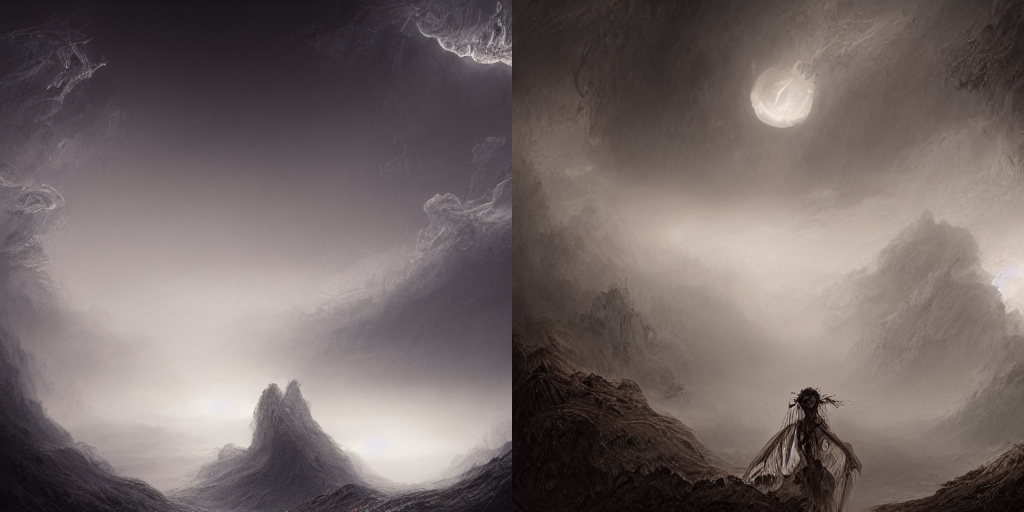

In [17]:
image_grid(all_images, 1, num_cols)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

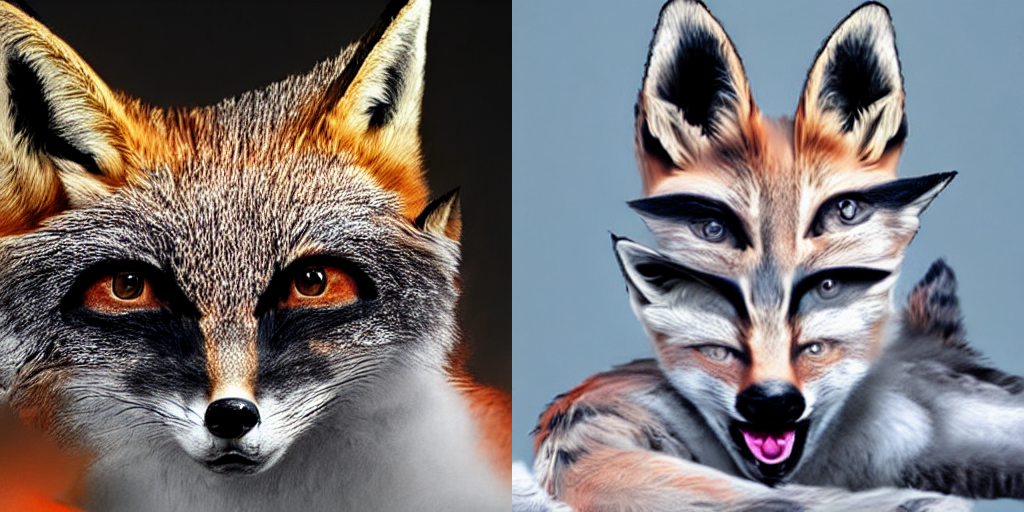

In [18]:
prompt = "🤳🦊 ♂ * nuzzles * 🖼 * blushez * 🎨 uwu owo 😼 [ powerful furr lore | incantus erminae"

# Tune the guidance to control how closely the generations follow the prompt.
# Values between 7-11 usually work best
guidance_scale = 7

num_cols = 2
all_images = []
for _ in range(num_cols):
    images = pipe(prompt, guidance_scale=guidance_scale).images
    all_images.extend(images)
image_grid(all_images, 1, num_cols)

# push to hub

In [20]:
model_name = "text2imagev3"
description = f"""
THE FIRST TEST
"""

In [21]:
from huggingface_hub import notebook_login
notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [22]:
from huggingface_hub import HfApi, ModelCard, create_repo, get_full_repo_name

# Set up repo and upload files
hub_model_id = get_full_repo_name(model_name)
create_repo(hub_model_id)
api = HfApi()
api.upload_folder(folder_path=args.output_dir, path_in_repo="", repo_id=hub_model_id)

content = f"""
---
license: creativeml-openrail-m
tags:
- pytorch
- diffusers
- stable-diffusion
- text-to-image
- diffusion-models-class
- dreambooth-hackathon


## Usage

```python
from diffusers import StableDiffusionPipeline

pipeline = StableDiffusionPipeline.from_pretrained('{hub_model_id}')
image = pipeline().images[0]
image
```
"""

card = ModelCard(content)
hub_url = card.push_to_hub(hub_model_id)

Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/492M [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/335M [00:00<?, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.
